In [1]:
import pyroc
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

## Data

The below loads in a dataset comparing the performance of a risk score (Krebs-Goplerud) against common biomarkers for Ovarian cancer. This is the dataset originally used in the article by Delong, Delong, and Clarke-Pearson which described the statistical test implemented in pytest.

In [2]:
# Load CSV
data = pd.read_csv("tests/data/ovarian_cancer.csv", index_col="idx")

# Imputation (Median)
outcome = data.pop("outcome")

data.albumin = data.albumin.fillna(np.median(data.albumin.dropna()))
data.total_protein = data.total_protein.fillna(np.median(data.total_protein.dropna()))

data.rename(columns={
    'albumin': 'Albumin',
    'total_protein': 'Total Protein',
    'total_score': 'Krebs-Goplerud'
}, inplace=True)

print(f'Dataset size: {data.shape}')
# Show examples
data.head(5)

Dataset size: (49, 3)


,Albumin,Total Protein,Krebs-Goplerud
idx,,,
1,3.0,5.8,0
2,3.2,6.3,5
3,3.9,6.8,7
4,2.8,4.8,4
5,3.2,5.8,7


## Instantiate ROC object

The ROC object is used to calculate the area under the operator characteristic curve (AUROC).
The first argument should be the binary target (0s and 1s). The second argument should be a dataframe with the predictions to compare.

In [3]:
roc = pyroc.ROC(outcome, data)

Predictions are stored in a dictionary attribute named `preds`:

In [4]:
print(roc.preds.keys())
roc.preds['Krebs-Goplerud']

odict_keys(['Albumin', 'Total Protein', 'Krebs-Goplerud'])


array([0., 5., 7., 4., 7., 5., 2., 5., 5., 4., 4., 6., 4., 5., 5., 6., 6.,
       4., 6., 4., 4., 3., 2., 5., 5., 4., 4., 5., 6., 5., 4., 4., 3., 4.,
       5., 3., 4., 5., 1., 3., 2., 2., 3., 3., 3., 4., 5., 3., 5.])

## Value of the ROC

Upon initialization, the ROC object has calculated the AUROC for each prediction.

In [5]:
print(roc.auc)

[[0.72297297 0.6509009  0.68693694]]


As the predictions are stored in an OrderedDict, we can easily associate the AUC with each prediction.

In [6]:
auc = {pred_name: roc.auc[0, i] for i, pred_name in enumerate(roc.preds.keys())}
print(auc)

{'Albumin': 0.722972972972973, 'Total Protein': 0.6509009009009009, 'Krebs-Goplerud': 0.6869369369369369}


We may also acquire confidence intervals.

In [7]:
print(roc.preds.keys())
print(roc.ci()[0], 'lower')
print(roc.ci()[1], 'upper')

odict_keys(['Albumin', 'Total Protein', 'Krebs-Goplerud'])
[0.53737381 0.44915782 0.48093018] lower
[0.90857213 0.85264398 0.8929437 ] upper


## Plot ROC curves

The ROC object provides a convenient method for plotting ROC curves:

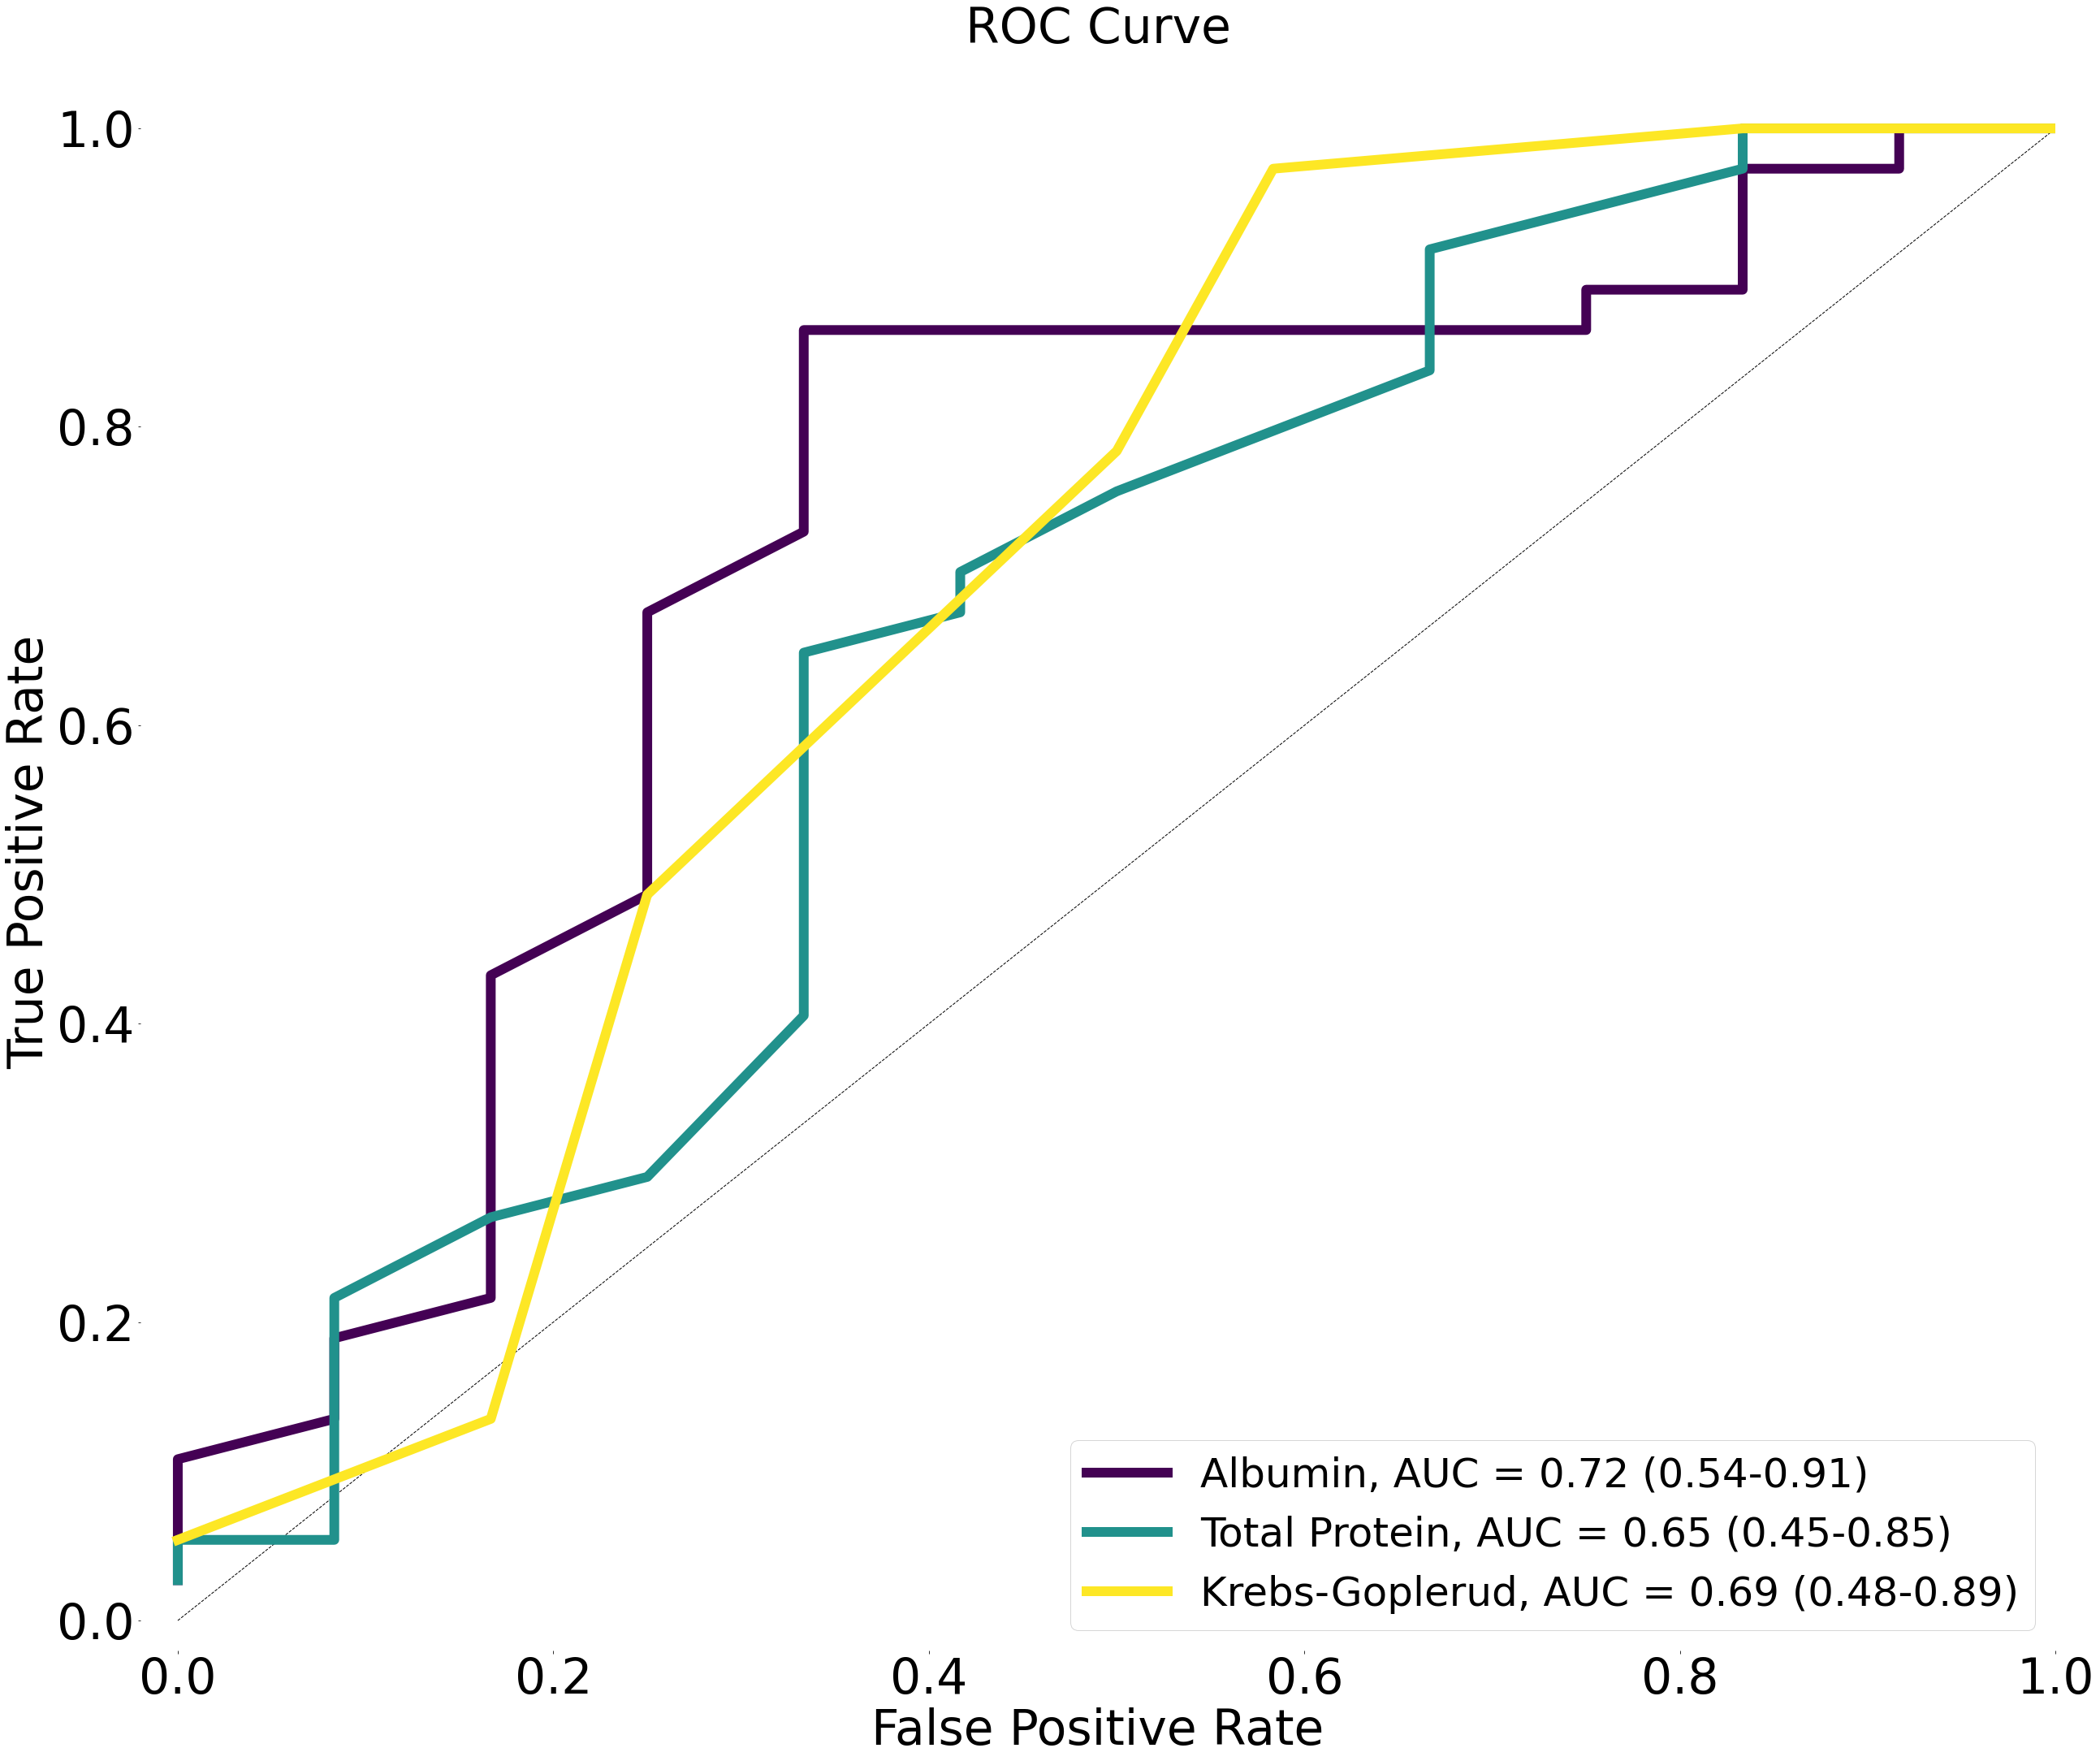

In [8]:
fig, ax = roc.plot()
plt.show()

## Statistically comparing different predictions

pyroc provides a method for comparing whether a given prediction has a statistically significantly different AUROC than another. The approach is described in an article by DeLong, DeLong, and Clarke-Pearson ([available here](https://doi.org/10.2307/2531595)). In the article, a general approach is described which allows comparing either two predictions directly, e.g. "is prediction A better than prediction B?", or comparing groups of predictions, e.g. "is prediction A significantly different than predictions B or C?". This is accomplished through a *contrast matrix*. We will demonstrate usage of the compare method through three common questions asked. As a reminder, we have three predictors in our example dataset: Albumin, Total Protein, and Krebs-Goplerud. We may thus ask:

* Is Krebs-Goplerud better than Total Protein?
* Is Krebs-Goplerud better than Albumin?
* Is Krebs-Goplerud better than at least one of Albumin or Total Protein?

Recall our predictions are:

In [9]:
print(roc.preds.keys())

odict_keys(['Albumin', 'Total Protein', 'Krebs-Goplerud'])


### Is Krebs-Goplerud different than Total Protein?

The first question focuses on direct comparison of two predictions. We use a single-row contrast: [0, -1, 1].


In [10]:
p, ci = roc.compare(np.array([
    [0, -1,  1],
]))
print(p, ci)

0.7245508480195271 [[-0.16439724  0.23646931]]


Our p-value is 0.72, which does not reject the null hypothesis. The AUROC Krebs-Goplerud score is not significantly different from the AUROC of the Total Protein biomarker.

### Is Krebs-Goplerud different than Albumin?

Similar to above, we are only comparing two of the three predictors. However, we are changing which predictor we are comparing again.

We use a single-row contrast: [-1, 0, 1].

In [11]:
p, ci = roc.compare(np.array([
    [-1, 0,  1],
]))
print(p, ci)

0.7009410788445647 [[-0.21994244  0.14787037]]


Again, no significant difference.

### Is Krebs-Goplerud better than at least one of Albumin and Total Protein?

This comparison is identical to the comparison made in page 844 of the original article by DeLong, DeLong, and Clarke-Pearson.

In [12]:
p, ci = roc.compare(np.array([
    [1, -1,  0],
    [1,  0, -1]
]))
print(p, ci)

0.422912563380643 [0.05063562 7.37775891]


If no contrast is provided and we have N classifiers C<sub>0,N</sub>, all classifiers in C<sub>1,N</sub> is compared to C<sub>0</sub> (same behaviour as example above)

In [13]:
p, ci = roc.compare()
print(p, ci)

0.422912563380643 [0.05063562 7.37775891]
